# RFA Proyect
Training MLP models over Diabetic_Retinopathy dataset step 5
- Transfer learning
- Fine tunning
- Data agmentation

## 5.0. Preprocess
 Uses parameter RESHAPE (in cell 1) to reshape the input params of the NN or not. It depends on the code run

In [1]:
! pip install keras_tuner
! pip install datasets
! pip install keras_cv

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import keras
import keras_tuner

keras.utils.set_random_seed(23)
import tensorflow as tf
import numpy as np

!export TF_CUDNN_WORKSPACE_LIMIT_IN_MB=1024
from datasets import load_dataset, DatasetDict, ClassLabel
import keras_cv

In [3]:
def prepare_inputs(image_label):
    image = tf.cast(image_label["image"], tf.uint8)
    return (image, tf.keras.utils.to_categorical(image_label["label"], num_classes=5))


ds = load_dataset("Rami/Diabetic_Retinopathy_Preprocessed_Dataset_256x256").shuffle(
    seed=23
)
ds = ds.cast_column(
    "label",
    ClassLabel(
        names=["Healthy", "Moderate DR", "Mild DR", "Proliferate DR", "Severe DR"]
    ),
)
ds = (
    ds["train"].to_tf_dataset().map(prepare_inputs, num_parallel_calls=tf.data.AUTOTUNE)
)
trainval, test = keras.utils.split_dataset(ds, right_size=0.20)
train, val = keras.utils.split_dataset(trainval, right_size=0.20)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
ds_train = train.cache()
ds_train = ds_train.shuffle(buffer_size=1000)
ds_train = ds_train.batch(128)
train_dataset = ds_train.prefetch(tf.data.AUTOTUNE)
ds_val = val.batch(128)
ds_val = ds_val.cache()
val_dataset = ds_val.prefetch(tf.data.AUTOTUNE)
ds_test = test.batch(128)
ds_test = ds_test.cache()
test_dataset = ds_test.prefetch(tf.data.AUTOTUNE)

In [5]:
for e in train_dataset.take(1):
    print(f"After preprocesss Image type {type(e[0])}")
    print(f"After preprocesss Input shape: {e[0].shape}")
    input_dim = tuple(e[0].shape.as_list()[1:])
    num_classes = 5

After preprocesss Image type <class 'tensorflow.python.framework.ops.EagerTensor'>
After preprocesss Input shape: (128, 256, 256, 3)


## 5.1. Transfer Learning

Resultados:

ResNet50V2 (BS 32)
- Test: Accuracy 70.18%
- Validation: Accuracy 71.13%

ResNet50V2 (BS 64)
- Test: Accuracy 70.91%
- Validation: Accuracy 71.36%

InceptionResNetV2 Test 67.45% (BS 64)


InceptionV3 Test 68.36% (BS 64)

In [6]:
# inputs = keras.Input(shape=input_dim)
# x = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)
# x = keras.layers.Resizing(229, 229, interpolation="nearest")(x)
# base_M = keras.applications.InceptionV3(weights='imagenet', include_top=False)
# base_M.trainable = False
# x = base_M(x, training=False)
# x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dense(units=500, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)
# predictions = keras.layers.Dense(num_classes, activation='softmax')(x)
# M = keras.models.Model(inputs=inputs, outputs=predictions)
# opt = keras.optimizers.Adam(learning_rate=0.00146)
# M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [7]:
inputs = keras.Input(shape=input_dim)
x = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)
x = keras.layers.Resizing(224, 224, interpolation="nearest")(x)
base_M = keras.applications.resnet_v2.ResNet50V2(include_top=False)
base_M.trainable = False
x = base_M(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(units=800, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(num_classes, activation="softmax")(x)
M = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adam(learning_rate=0.00146)
M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [8]:
filename = "Diabetic_Retinopathy_transfer_learning.keras"
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath=filename, monitor="val_accuracy", save_best_only=True, verbose=1
)
reduce_cb = keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy", factor=0.3, patience=5, min_delta=0.0005, min_lr=0.0
)
early_cb = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=10, min_delta=0.0005
)
H = M.fit(
    train_dataset,
    batch_size=64,
    epochs=500,
    validation_data=val_dataset,
    verbose=0,
    callbacks=[checkpoint_cb, early_cb, reduce_cb],
)


Epoch 1: val_accuracy improved from -inf to 0.64545, saving model to Diabetic_Retinopathy_transfer_learning.keras

Epoch 2: val_accuracy improved from 0.64545 to 0.67727, saving model to Diabetic_Retinopathy_transfer_learning.keras

Epoch 3: val_accuracy improved from 0.67727 to 0.69091, saving model to Diabetic_Retinopathy_transfer_learning.keras

Epoch 4: val_accuracy improved from 0.69091 to 0.69318, saving model to Diabetic_Retinopathy_transfer_learning.keras

Epoch 5: val_accuracy did not improve from 0.69318

Epoch 6: val_accuracy did not improve from 0.69318

Epoch 7: val_accuracy improved from 0.69318 to 0.69773, saving model to Diabetic_Retinopathy_transfer_learning.keras

Epoch 8: val_accuracy did not improve from 0.69773

Epoch 9: val_accuracy did not improve from 0.69773

Epoch 10: val_accuracy did not improve from 0.69773

Epoch 11: val_accuracy improved from 0.69773 to 0.70455, saving model to Diabetic_Retinopathy_transfer_learning.keras

Epoch 12: val_accuracy improved 

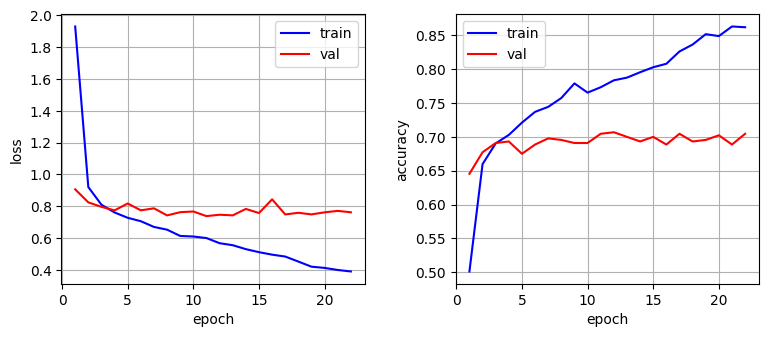

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history["loss"]) + 1)
ax = axes[0]
ax.grid()
# ax.set_xticks(xx)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.plot(xx, H.history["loss"], color="b", label="train")
ax.plot(xx, H.history["val_loss"], color="r", label="val")
ax.legend()
ax = axes[1]
ax.grid()
# ax.set_xticks(xx)
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.plot(xx, H.history["accuracy"], color="b", label="train")
ax.plot(xx, H.history["val_accuracy"], color="r", label="val")
ax.legend();

In [10]:
score = keras.models.load_model(filename).evaluate(test_dataset, verbose=0)
print(f"Loss: {score[0]:.4} Precisión: {score[1]:.2%}")

Loss: 0.777 Precisión: 70.73%


## 5.2. Fine Tuning
Fine tune the model obtained from transfer learning in 6.
- Descongelando Backbone3=71.64%% en Test 72.72% en val
- Todo Backbone= 70% Test

In [11]:
M.summary(line_length=95, positions=[0.59, 0.82, 0.94, 1.0], show_trainable=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━┓
┃ Layer (type)                                      ┃ Output Shape        ┃    Param # ┃ Tra… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━┩
│ input_layer (InputLayer)                          │ (None, 256, 256, 3) │          0 │  -   │
├───────────────────────────────────────────────────┼─────────────────────┼────────────┼──────┤
│ rescaling (Rescaling)                             │ (None, 256, 256, 3) │          0 │  -   │
├───────────────────────────────────────────────────┼─────────────────────┼────────────┼──────┤
│ resizing (Resizing)                               │ (None, 224, 224, 3) │          0 │  -   │
├───────────────────────────────────────────────────┼─────────────────────┼────────────┼──────┤
│ resnet50v2 (Functional)                           │ (None, 7, 7, 2048)  │ 23,564,800 │  N   │
├───────────────────────────────────────────────────┼─────────────────────┼────────────┼──────┤
│ global_average_pooling2d (GlobalAveragePooling2D) │ (None, 2048)        │          0 │  -   │
├───────────────────────────────────────────────────┼─────────────────────┼────────────┼──────┤
│ dense (Dense)                                     │ (None, 800)         │  1,639,200 │  Y   │
├───────────────────────────────────────────────────┼─────────────────────┼────────────┼──────┤
│ dropout (Dropout)                                 │ (None, 800)         │          0 │  -   │
├───────────────────────────────────────────────────┼─────────────────────┼────────────┼──────┤
│ dense_1 (Dense)                                   │ (None, 5)           │      4,005 │  Y   │
└───────────────────────────────────────────────────┴─────────────────────┴────────────┴──────┘

 Total params: 28,494,417 (108.70 MB)

 Trainable params: 1,643,205 (6.27 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 3,286,412 (12.54 MB)

In [12]:
for i, layer in enumerate(M.layers[3].layers):
    print(
        f"{i}: {layer.name} -  - {'Trainable' if layer.trainable else 'Non-trainable'}"
    )

0: input_layer_1 -  - Non-trainable
1: conv1_pad -  - Non-trainable
2: conv1_conv -  - Non-trainable
3: pool1_pad -  - Non-trainable
4: pool1_pool -  - Non-trainable
5: conv2_block1_preact_bn -  - Non-trainable
6: conv2_block1_preact_relu -  - Non-trainable
7: conv2_block1_1_conv -  - Non-trainable
8: conv2_block1_1_bn -  - Non-trainable
9: conv2_block1_1_relu -  - Non-trainable
10: conv2_block1_2_pad -  - Non-trainable
11: conv2_block1_2_conv -  - Non-trainable
12: conv2_block1_2_bn -  - Non-trainable
13: conv2_block1_2_relu -  - Non-trainable
14: conv2_block1_0_conv -  - Non-trainable
15: conv2_block1_3_conv -  - Non-trainable
16: conv2_block1_out -  - Non-trainable
17: conv2_block2_preact_bn -  - Non-trainable
18: conv2_block2_preact_relu -  - Non-trainable
19: conv2_block2_1_conv -  - Non-trainable
20: conv2_block2_1_bn -  - Non-trainable
21: conv2_block2_1_relu -  - Non-trainable
22: conv2_block2_2_pad -  - Non-trainable
23: conv2_block2_2_conv -  - Non-trainable
24: conv2_block2_

In [13]:
M = keras.models.load_model("Diabetic_Retinopathy_transfer_learning.keras")

# Descongelar solo las últimas 'N' capas (el último bloque)
for layer in M.layers[3].layers[
    154:
]:  # Descongelar las últimas 10 capas (último bloque conv5_x)
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = True
# for layer in M.layers:
#  if not isinstance(layer, keras.layers.BatchNormalization):
#   layer.trainable = True
# Early stopping
reduce_cb = keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy", factor=0.3, patience=5, min_delta=0.0005, min_lr=0.0
)
early_cb = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=10, min_delta=0.0005
)
opt = keras.optimizers.Adam(learning_rate=1e-5)
M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
filename = "Diabetic_Retinopathy_fine-tuning.keras"
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath=filename, monitor="val_accuracy", save_best_only=True, verbose=1
)

H = M.fit(
    train_dataset,
    batch_size=64,
    epochs=100,
    validation_data=val_dataset,
    verbose=0,
    callbacks=[checkpoint_cb, early_cb, reduce_cb],
)


Epoch 1: val_accuracy improved from -inf to 0.70909, saving model to Diabetic_Retinopathy_fine-tuning.keras

Epoch 2: val_accuracy improved from 0.70909 to 0.72045, saving model to Diabetic_Retinopathy_fine-tuning.keras

Epoch 3: val_accuracy did not improve from 0.72045

Epoch 4: val_accuracy did not improve from 0.72045

Epoch 5: val_accuracy did not improve from 0.72045

Epoch 6: val_accuracy did not improve from 0.72045

Epoch 7: val_accuracy did not improve from 0.72045

Epoch 8: val_accuracy improved from 0.72045 to 0.72727, saving model to Diabetic_Retinopathy_fine-tuning.keras

Epoch 9: val_accuracy did not improve from 0.72727

Epoch 10: val_accuracy did not improve from 0.72727

Epoch 11: val_accuracy did not improve from 0.72727

Epoch 12: val_accuracy did not improve from 0.72727

Epoch 13: val_accuracy did not improve from 0.72727

Epoch 14: val_accuracy did not improve from 0.72727

Epoch 15: val_accuracy did not improve from 0.72727

Epoch 16: val_accuracy did not impro

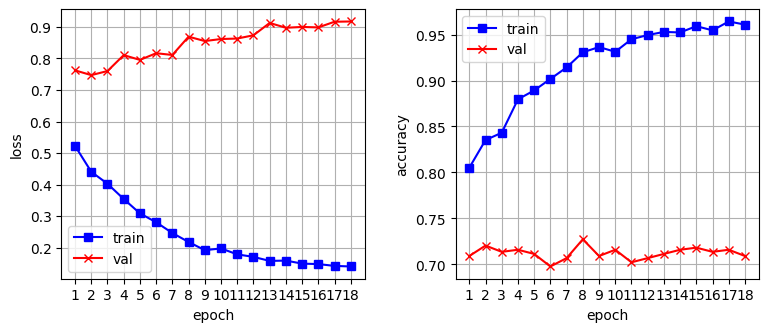

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history["loss"]) + 1)
ax = axes[0]
ax.grid()
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(xx)
ax.plot(xx, H.history["loss"], color="b", marker="s", label="train")
ax.plot(xx, H.history["val_loss"], color="r", marker="x", label="val")
ax.legend()
ax = axes[1]
ax.grid()
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.set_xticks(xx)
ax.plot(xx, H.history["accuracy"], color="b", marker="s", label="train")
ax.plot(xx, H.history["val_accuracy"], color="r", marker="x", label="val")
ax.legend();

In [15]:
score = keras.models.load_model(filename).evaluate(test_dataset, verbose=0)
print(f"Loss: {score[0]:.4} Precisión: {score[1]:.2%}")

Loss: 0.9252 Precisión: 71.45%


## 5.3 Data augmentation.
- Test:71.45% - Random Flip Val: 73%
- Test 71.45% - Random Augment: 71.81%
- Test 71.45% - CUt-MIx Val:72.18%


In [20]:
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=1.0,
)
random_flip = keras_cv.layers.RandomFlip("horizontal")
cut_mix = keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp()


def cut_augmentation(images, labels):

    cm = cut_mix({"images": images, "labels": labels})
    mu = mix_up({"images": cm["images"], "labels": cm["labels"]})
    return mu["images"], mu["labels"]


def augment_images(images, labels):
    images = random_flip(images)
    return images, labels


def augment_data(images, labels):
    images = rand_augment(images)
    return images, labels


# train_ds = trainval.map(augment_images, num_parallel_calls=tf.data.AUTOTUNE, )
# batch_size = 32;
# train_ds = train_ds.cache().shuffle(10 * batch_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# For CUT-MIX
batch_size = 32
train_ds = (
    trainval.cache()
    .shuffle(10 * batch_size)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
train_ds = train_ds.map(
    lambda images, labels: cut_augmentation(images, labels),
    num_parallel_calls=tf.data.AUTOTUNE,
)

In [21]:
import time

start = time.time()
M = keras.models.load_model("Diabetic_Retinopathy_fine-tuning.keras")
M.summary(line_length=95, positions=[0.59, 0.82, 0.94, 1.0], show_trainable=True)
for layer in M.layers[3].layers[
    154:
]:  # Descongelar las últimas 10 capas (último bloque conv5_x)
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = True
opt = keras.optimizers.Adam(learning_rate=1e-5)
M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
check = keras.callbacks.ModelCheckpoint(
    "Diabetic_Retinopathy_da.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1,
)
reduce = keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy", factor=0.3, patience=5, min_delta=0.0005, min_lr=0.0
)
early = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=10, min_delta=0.0005
)
H = M.fit(
    train_ds,
    epochs=100,
    validation_data=test_dataset,
    verbose=1,
    callbacks=[check, early, reduce],
)
print("Tiempo (hh:mm:ss):", time.strftime("%H:%M:%S", time.gmtime(time.time() - start)))

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━┓
┃ Layer (type)                                      ┃ Output Shape        ┃    Param # ┃ Tra… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━┩
│ input_layer (InputLayer)                          │ (None, 256, 256, 3) │          0 │  -   │
├───────────────────────────────────────────────────┼─────────────────────┼────────────┼──────┤
│ rescaling (Rescaling)                             │ (None, 256, 256, 3) │          0 │  -   │
├───────────────────────────────────────────────────┼─────────────────────┼────────────┼──────┤
│ resizing (Resizing)                               │ (None, 224, 224, 3) │          0 │  -   │
├───────────────────────────────────────────────────┼─────────────────────┼────────────┼──────┤
│ resnet50v2 (Functional)                           │ (None, 7, 7, 2048)  │ 23,564,800 │  N   │
├───────────────────────────────────────────────────┼─────────────────────┼────────────┼──────┤
│ global_average_pooling2d (GlobalAveragePooling2D) │ (None, 2048)        │          0 │  -   │
├───────────────────────────────────────────────────┼─────────────────────┼────────────┼──────┤
│ dense (Dense)                                     │ (None, 800)         │  1,639,200 │  Y   │
├───────────────────────────────────────────────────┼─────────────────────┼────────────┼──────┤
│ dropout (Dropout)                                 │ (None, 800)         │          0 │  -   │
├───────────────────────────────────────────────────┼─────────────────────┼────────────┼──────┤
│ dense_1 (Dense)                                   │ (None, 5)           │      4,005 │  Y   │
└───────────────────────────────────────────────────┴─────────────────────┴────────────┴──────┘

 Total params: 58,395,217 (222.76 MB)

 Trainable params: 16,593,605 (63.30 MB)

 Non-trainable params: 8,614,400 (32.86 MB)

 Optimizer params: 33,187,212 (126.60 MB)

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5949 - loss: 1.4529
Epoch 1: val_accuracy improved from -inf to 0.67455, saving model to Diabetic_Retinopathy_da.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 43s 463ms/step - accuracy: 0.5946 - loss: 1.4512 - val_accuracy: 0.6745 - val_loss: 0.8850 - learning_rate: 1.0000e-05
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.6030 - loss: 1.1757
Epoch 2: val_accuracy improved from 0.67455 to 0.68545, saving model to Diabetic_Retinopathy_da.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 41s 504ms/step - accuracy: 0.6030 - loss: 1.1759 - val_accuracy: 0.6855 - val_loss: 0.8671 - learning_rate: 1.0000e-05
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6252 - loss: 1.1157
Epoch 3: val_accuracy improved from 0.68545 to 0.69636, saving model to Diabetic_Retinopathy_da.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 33s 389ms/step - accuracy: 0.6249 - loss: 1.1161 - val_accuracy: 0.6964 - val_loss: 0.8426 - learning_rate: 1.0000e-0

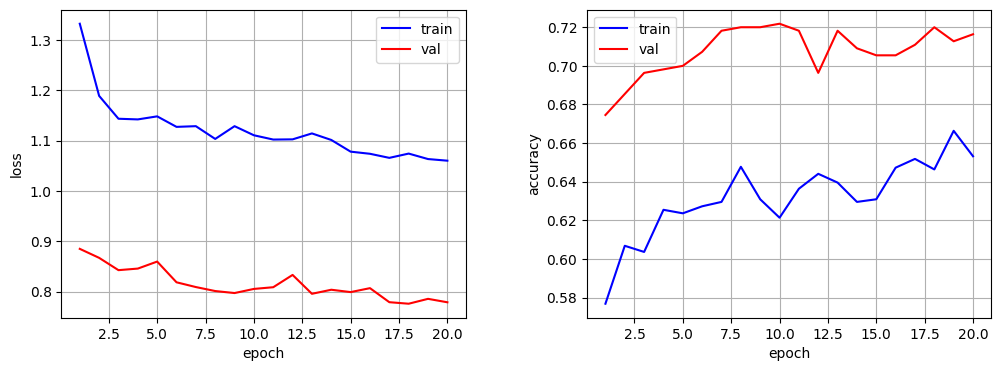

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history["loss"]) + 1)
ax = axes[0]
ax.grid()
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
# ax.set_xticks(xx)
ax.plot(xx, H.history["loss"], color="b", label="train")
ax.plot(xx, H.history["val_loss"], color="r", label="val")
ax.legend()
ax = axes[1]
ax.grid()
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
# ax.set_xticks(xx)
ax.plot(xx, H.history["accuracy"], color="b", label="train")
ax.plot(xx, H.history["val_accuracy"], color="r", label="val")
ax.legend();

In [23]:
score = keras.models.load_model(filename).evaluate(test_dataset, verbose=0)
print(f"Loss: {score[0]:.4} Precisión: {score[1]:.2%}")

Loss: 0.9252 Precisión: 71.45%
